# Discrete Event Simulation in Python

Discrete Event Simulation (DES) is a way of modelling *queuing problems*. In a DES, *entities* flow through (and queue for) *discrete sequential processes* that use *resources*.

DES is typically used to model processes and pathways. For example, what happens to patients when they arrive at the Emergency Department of a Hospital. Therefore, DES is useful for asking "what if?" questions about process/pathway changes.

Let's take the next figure as an example. We can see the pathway of a patient in a small Hospital. In gray we see the different activities for the patient, in blue we see the resources that this patient is using, and in red and green we see the outcomes.

![img](https://drive.google.com/uc?id=1_H2H4lYfh9XY_O-t-mPTHfBTMCiFN7q_)

In **simpy** we will use the following terminology for describing the different DES elements:

* **Entities** are the things flowing through the sequential processes in the model (e.g. patients, telephone calls, blood test results).
* **Generators** are the way in which entities enter the model and come into being (e.g. brought in by paramedics, self-presenting). Sometimes you will only have one generator, but some other times you will need multiple generators.
* **Inter-arrival Times** specify the time between entities being generated (arriving in the model). You may have different inter-arrival times for different generators.
* **Activities/Servers** represent the activities that happen to entities (e.g. triage, treatment, ward admission).
* **Activity/Server Time** represents the amount of time it takes for an activity to happen to an entity.
* **Resources** are required for activities to take place and may be shared between activities (e.g. nurse, doctor, receptionist, bed).
* **Queues** are where entities are held until an activity has capacity and the required resources to begin.
* **Sinks** are how entities leave the model. Like generators, you can have more than one (e.g. Out, Died).



Let's see a very simple example of using `simpy` for simulating a hairdresser. We will start installing the library in case we dont have it already:

In [2]:
!pip install simpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In the next chunk we see the libraries to use in the simulation and the basic predefined parameters or assumptions of the model. We observe that a seed, the number of hairdressers, the minimum and maximum times for a haircut, the expected arrival time between customers, the simulation time, and the total number of customers we expect are specified. Additionally, three global variables are initialized that we will use to collect simulation data: wait time, service time, and the service completion minute.

In [15]:
import random
import math
import simpy
import numpy as np

In [16]:
SEED = 2023
WORKERS = 1
MIN_TIME_WITH_CUSTOMER = 15 
MAX_TIME_WITH_CUSTOMER = 30
ARRIVALS_TIME = 10 # We expect a customer every 10 minutes
SIMULATION_TIME = 120
TOTAL_CUSTOMERS = 10
tw  = 0.0 # Initialization of time waiting
st  = 0.0 # Initialization of service time
end = 0.0 # Minute of finalization

In this initial function, we will define the hair-cut event. Given an initial time for the hair-cut, we will generate a random number to estimate the time of the hair-cut randomly for each client. Finally, we execute this event in the simulation in terms of time and record the data for further analysis.

In [17]:
def haircut(customer):
	global st  # We access to the globally declared "st" variable
	R = random.random()  # Random number between 0 and 1
	time = MAX_TIME_WITH_CUSTOMER - MIN_TIME_WITH_CUSTOMER  
	haircut_time = MIN_TIME_WITH_CUSTOMER + (time*R) # Uniform distribution for the haircut times
	yield env.timeout(haircut_time) # We run this time in the simulation
	print(" |=) Haircut ready for %s in %.2f minutes" % (customer,haircut_time))
	st = st + haircut_time # We sum the time to the service time

The "customer" function will generate the customer's journey during the hair cutting process. We will record the time when the customer arrives, generate a queue, and start recording waiting times, in order to subsequently record the cutting time and simulate this process in terms of time in the global simulation. Finally, we will record the completion time of the haircut for the customer.

In [18]:
def customer (env, name, worker):
	global tw
	global end
	arrival = env.now # store arrival time for client
	print ("---> %s arrives at %.2f" % (name, arrival))
	with workers.request() as request: # Wait for turn
		yield request # Start Haircut
		come_in = env.now # We store the starting minute
		wait = come_in - arrival # Calculate waiting time
		tw = tw + wait # Sum up waiting times
		print ("**** %s starts haircut at %.2f with a waiting time of %.2f" % (name, come_in, wait))
		yield env.process(haircut(name)) # Start Haircut process
		leave = env.now # Stores ending minute 
		print ("<--- %s leaves the Hairdresser at %.2f" % (name, leave))
		end = leave # Conserves globally the last minute of the simulation

The main function will generate pseudo-random times for each of the clients, and execute the previous functions for each one of them, registering all the data for subsequent analysis.

In [20]:
def main(env, worker):
	arrival = 0
	i = 0
	for i in range(TOTAL_CUSTOMERS): # for n customers
		R = random.random()
		arrival = random.expovariate(1/ARRIVALS_TIME) # Simulate arrivals from 
    #exponential given the previous random number
		yield env.timeout(arrival)  # simulation time between arrivals
		i += 1
		env.process(customer(env, 'Customer %d' % i, worker)) 

To begin the simulation, we must set an initial seed. Then, we can initialize the simulation environment and allocate the resources (in this case, only the workers). We generate the simulation process using the main function and execute the simulation environment. Additionally, we will use the variables saved at the beginning to calculate a series of indicators of interest for the simulation that will be displayed at the end of the output.

In [22]:
print ("------------------- Welcome to the Hairdresser ------------------")
random.seed (SEED)  # set the seed
env = simpy.Environment() # Start the enviroment
workers = simpy.Resource(env, WORKERS) # Create the resources (workers)
env.process(main(env, workers)) # Starts main programm
env.run() # Starts the simulation

print ("\n---------------------------------------------------------------------")
print ("\nIndicators obtained: ")

aql = tw / end
print ("\nAverage queue length: %.2f" % aql)
awt = tw / TOTAL_CUSTOMERS
print ("Average waiting time = %.2f" % awt)
hu = (st / end) / WORKERS
print ("Hairdresser usage = %.2f" % hu)
print ("\n---------------------------------------------------------------------")

------------------- Welcome to the Hairdresser ------------------
---> Customer 1 arrives at 35.71
**** Customer 1 starts haircut at 35.71 with a waiting time of 0.00
---> Customer 2 arrives at 39.57
---> Customer 3 arrives at 40.62
---> Customer 4 arrives at 44.24
---> Customer 5 arrives at 56.91
 |=) Haircut ready for Customer 1 in 23.57 minutes
<--- Customer 1 leaves the Hairdresser at 59.27
**** Customer 2 starts haircut at 59.27 with a waiting time of 19.70
---> Customer 6 arrives at 59.56
---> Customer 7 arrives at 59.73
---> Customer 8 arrives at 69.49
---> Customer 9 arrives at 84.73
 |=) Haircut ready for Customer 2 in 29.67 minutes
<--- Customer 2 leaves the Hairdresser at 88.94
**** Customer 3 starts haircut at 88.94 with a waiting time of 48.32
 |=) Haircut ready for Customer 3 in 28.51 minutes
<--- Customer 3 leaves the Hairdresser at 117.45
**** Customer 4 starts haircut at 117.45 with a waiting time of 73.21
---> Customer 10 arrives at 120.26
 |=) Haircut ready for Custo

After concluding the simulation, we can utilize the data collected to optimize the system that we have designed. In this instance, it appears that a single employee is insufficient to satisfy the established demand, resulting in a rather significant wait time to be attended to. We could examine the potential outcomes of hiring another worker.

We can also execute the simulation for a specific time instead of a specific number of customers. We just need to change the line "env.run" to the following command:

```
env.run(until=SIMULATION_TIME)
```
Where SIMULATION_TIME is a variable declared at the beginning of the program. Also, we must adjust the main function. Instead of `for i in range(TOTAL_CUSTOMERS):`, we will use an infinite loop:

```
while True:
```

In [24]:
def main(env, worker):
	arrival = 0
	i = 0
	while True: # for n customers
		R = random.random()
		arrival = random.expovariate(1/ARRIVALS_TIME)
		yield env.timeout(arrival)
		i += 1
		env.process(customer(env, 'Customer %d' % i, worker)) 

print ("------------------- Welcome to the Hairdresser ------------------")
random.seed (SEED)  # set the seed
env = simpy.Environment() # Start the enviroment
workers = simpy.Resource(env, WORKERS) # Create the resources (workers)
env.process(main(env, workers)) # Starts main programm
env.run(until = SIMULATION_TIME) # Starts the simulation

print ("\n---------------------------------------------------------------------")
print ("\nIndicators obtained: ")

aql = tw / end
print ("\nAverage queue length: %.2f" % aql)
awt = tw / TOTAL_CUSTOMERS
print ("Average waiting time = %.2f" % awt)
hu = (st / end) / WORKERS
print ("Hairdresser usage = %.2f" % hu)
print ("\n---------------------------------------------------------------------")

------------------- Welcome to the Hairdresser ------------------
---> Customer 1 arrives at 35.71
**** Customer 1 starts haircut at 35.71 with a waiting time of 0.00
---> Customer 2 arrives at 39.57
---> Customer 3 arrives at 40.62
---> Customer 4 arrives at 44.24
---> Customer 5 arrives at 56.91
 |=) Haircut ready for Customer 1 in 23.57 minutes
<--- Customer 1 leaves the Hairdresser at 59.27
**** Customer 2 starts haircut at 59.27 with a waiting time of 19.70
---> Customer 6 arrives at 59.56
---> Customer 7 arrives at 59.73
---> Customer 8 arrives at 69.49
---> Customer 9 arrives at 84.73
 |=) Haircut ready for Customer 2 in 29.67 minutes
<--- Customer 2 leaves the Hairdresser at 88.94
**** Customer 3 starts haircut at 88.94 with a waiting time of 48.32
 |=) Haircut ready for Customer 3 in 28.51 minutes
<--- Customer 3 leaves the Hairdresser at 117.45
**** Customer 4 starts haircut at 117.45 with a waiting time of 73.21

--------------------------------------------------------------

For a much more complex application of simulation modeling techniques you can read this [paper](https://www.tandfonline.com/doi/full/10.1080/17477778.2020.1751570) about how these techniques could help in reducing the impact of the COVID-19.

### Discrete Events Simulation with `simpy`

When we create any simulation in SimPy, the first decision we must make is whether to use an Object-Oriented approach or not. In this course, we will explore how to perform DES simulations in SimPy without using an Object-Oriented approach, as it will be much simpler to carry out technically. Using Object-Oriented Programming to perform simulations with SimPy will allow us to have more flexibility when defining our systems, but these models will be much more complex.

### Generator Functions

**Conventional functions** in Python are called, and then run with some (optional) inputs, and then finish (usually by returning some output).

**Generator functions** remember where they were and what they did when control is passed back (they retain their "local state"), so that they can continue where they left off, and can be used as powerful *iterators* (for and while loops are other examples of *iterators*).

This is very useful when we want a specific state to be maintained (e.g. during a simulation run). Let's look at a very simple example of a generator function to see how they work compared to a normal function:

In [25]:
# Normal Function
def conventional_counter():
  count = 0
  while True: # keep doing this indefinitely
    count += 1 # add 1 to the count
    return count 
    # the return keyword will exit the function returning that value

a = conventional_counter()
print(a)
a = conventional_counter()
print(a)
a = conventional_counter()
print(a)
a = conventional_counter()
print(a)

1
1
1
1


In [26]:
# Generator Function
def counter_generator():
  count = 0
  while True: # keep doing this indefinitely
    count += 1 # add 1 to the count
    yield count 
    # On the other hand, yield statement identifies this as a generator function.
    # Yield is like a return, but it tells the generator function to freeze
    # in place and remember where it was ready for the next time it's called

my_generator = counter_generator()

print(next(my_generator))
print(next(my_generator))
print(next(my_generator))
print(next(my_generator))

1
2
3
4


### Applying a Generator

Let's take a look at a very simple example of a DES to learn how to use generators within discrete event simulations. The following graph describes a very simple experiment in which we simulate the queue of patients arriving at a weight loss clinic. We will have inter-arrival times of consultations, the entities as patients, and the activity times will be represented by the consultation time of the patients with the nurse.

![img](https://drive.google.com/uc?id=1EHqU5SefMOqhFnJU0P1o7Q13dOpcnvyU)



In [28]:
import simpy
import random

# Arrivals generator function
def patient_generator(env, wl_inter, mean_consult, nurse):
  patient_id = 1

  # keep generating indefinitely
  while True:
    # Create instance of activity generator
    wp = activity_generator(env,mean_consult,nurse,patient_id)

    # run the activity generator for this patient
    env.process(wp)

    # Sample time until next patient
    t = random.expovariate(1/wl_inter)

    # Freeze until that time has passed
    yield env.timeout(t)

    patient_id += 1 

In [29]:
# Activity generator function. This activity generator function normally
# describes arrivals journey
def activity_generator(env, mean_consult, nurse, patient_id):
  time_entered_queue = env.now
  print ("---> Patient %s arrives at %.2f" % (patient_id, time_entered_queue))

  # request a nurse from the Resources
  with nurse.request() as req: 
    # Freeze until the request can be met
    yield req
    
    # Calculate time patient was queuing
    time_left_queue = env.now
    print (" <--- Patient %s left queue at %.2f" % (patient_id, time_left_queue))

    time_in_queue = time_left_queue - time_entered_queue
    print (" \\(o-o)/ Patient %s was waiting for %.2f minutes" % (patient_id, time_left_queue))

    # Sample time spent with nurse
    consultation_time = random.expovariate(1/mean_consult)

    # Freeze until that time has passed
    yield env.timeout(consultation_time)

In [31]:
random.seed(2023)
# Set up the simulation enviroment
env = simpy.Environment()

# Set up resources
nurse = simpy.Resource(env, capacity = 1)

# Set up parameters
wl_inter = 5
mean_consult = 6

# Start the arrivals generator
env.process(patient_generator(env,wl_inter, mean_consult, nurse))

# Run the simulation
env.run(until=120)

---> Patient 1 arrives at 0.00
 <--- Patient 1 left queue at 0.00
 \(o-o)/ Patient 1 was waiting for 0.00 minutes
---> Patient 2 arrives at 2.41
---> Patient 3 arrives at 11.70
---> Patient 4 arrives at 13.63
---> Patient 5 arrives at 17.86
---> Patient 6 arrives at 19.92
---> Patient 7 arrives at 20.44
---> Patient 8 arrives at 21.10
 <--- Patient 2 left queue at 21.42
 \(o-o)/ Patient 2 was waiting for 21.42 minutes
---> Patient 9 arrives at 22.91
 <--- Patient 3 left queue at 28.58
 \(o-o)/ Patient 3 was waiting for 28.58 minutes
---> Patient 10 arrives at 29.25
---> Patient 11 arrives at 30.57
 <--- Patient 4 left queue at 30.73
 \(o-o)/ Patient 4 was waiting for 30.73 minutes
 <--- Patient 5 left queue at 31.90
 \(o-o)/ Patient 5 was waiting for 31.90 minutes
 <--- Patient 6 left queue at 32.00
 \(o-o)/ Patient 6 was waiting for 32.00 minutes
 <--- Patient 7 left queue at 34.71
 \(o-o)/ Patient 7 was waiting for 34.71 minutes
 <--- Patient 8 left queue at 40.57
 \(o-o)/ Patient 8 

### Linear Process with more than one sequential activity

That was an example of a very simple DES model, but in mos DES models, we will have more than one activity in our system.

Let's first consider a simple linear example, where patients queue for one activity, and then queue for a second activity as follows:

![img](https://drive.google.com/uc?id=168PLjpkeg1B9Xsxg4fJKt7bzdTwbz-0j)

We will have two activities that patients queue for sequentially, and two types of resource: receptionists and nurses. Let's see how can we implement that in SimPy.

In [33]:
import simpy
import random

# Arrival generator for hospital
def patient_generator_h(env, h_inter, mean_register, mean_triage, receptionist, nurse):
  patient_id = 1

  while True:
    p = activity_generator_h(env,mean_register,mean_triage,receptionist,nurse,patient_id)
    env.process(p)
    t = random.expovariate(1/h_inter)

    yield env.timeout(t)
    patient_id += 1

In [34]:
# Activity generator
def activity_generator_h(env, mean_register, mean_triage, receptionist, nurse, patient_id):
  time_entered_queue_registration = env.now

  with receptionist.request() as req:
    yield req

    time_left_queue_registration = env.now
    time_in_queue_registration = time_left_queue_registration - time_entered_queue_registration
    print (" \\(o-o)/ Patient %s queued for registration %.2f minutes" % (patient_id, time_in_queue_registration))

    registration_time = random.expovariate(1/mean_register)
    yield env.timeout(registration_time)

  time_entered_queue_triage = env.now

  with nurse.request() as req:
    yield req

    time_left_queue_triage = env.now
    time_in_queue_triage = time_left_queue_triage - time_entered_queue_triage
    print (" \\(o-o)/ Patient %s queued for triage %.2f minutes" % (patient_id, time_in_queue_triage))

    triage_time = random.expovariate(1/mean_triage)
    yield env.timeout(triage_time)


In [35]:
random.seed(2023)
env = simpy.Environment()
receptionist = simpy.Resource(env, capacity = 1)
nurse = simpy.Resource(env, capacity = 1)

h_inter = 8
mean_register = 2
mean_triage = 5

env.process(patient_generator_h(env, h_inter, mean_register, mean_triage, receptionist, nurse))
env.run(until=120)

 \(o-o)/ Patient 1 queued for registration 0.00 minutes
 \(o-o)/ Patient 1 queued for triage 0.00 minutes
 \(o-o)/ Patient 2 queued for registration 3.28 minutes
 \(o-o)/ Patient 2 queued for triage 0.24 minutes
 \(o-o)/ Patient 3 queued for registration 0.00 minutes
 \(o-o)/ Patient 3 queued for triage 0.00 minutes
 \(o-o)/ Patient 4 queued for registration 0.00 minutes
 \(o-o)/ Patient 4 queued for triage 0.00 minutes
 \(o-o)/ Patient 5 queued for registration 0.00 minutes
 \(o-o)/ Patient 5 queued for triage 0.00 minutes
 \(o-o)/ Patient 6 queued for registration 5.49 minutes
 \(o-o)/ Patient 7 queued for registration 6.99 minutes
 \(o-o)/ Patient 8 queued for registration 7.29 minutes
 \(o-o)/ Patient 6 queued for triage 3.05 minutes
 \(o-o)/ Patient 9 queued for registration 10.79 minutes
 \(o-o)/ Patient 10 queued for registration 4.38 minutes
 \(o-o)/ Patient 11 queued for registration 0.00 minutes
 \(o-o)/ Patient 7 queued for triage 14.15 minutes
 \(o-o)/ Patient 8 queued for 

### Non-Linear process with more than one sequential activity

Often in real world systems, not everything is linear. Different things might happen depending on certain conditions. For example, after triage a patient might be referred to a Ambulatory Care to diagnose a treat the patient without being admitted to the hospital overnight.

![img](https://drive.google.com/uc?id=1K-4NWslBeU4KHWF7JlmXBP7-gzg2VPiu)

Let's see how can we create these two pathways using SimPy in the simulation.

In [37]:
import simpy
import random

# Arrival generator for hospital
def patient_generator_h(env, h_inter, mean_register, mean_triage, mean_ac_assessment, mean_h_assessment, receptionist, nurse, ac_doctor, h_doctor):
  patient_id = 1

  while True:
    p = activity_generator_h(env, mean_register, mean_triage, mean_ac_assessment, mean_h_assessment, receptionist, nurse, ac_doctor, h_doctor, patient_id)
    env.process(p)
    t = random.expovariate(1/h_inter)

    yield env.timeout(t)
    patient_id += 1

In [38]:
# Activity generator
def activity_generator_h(env, mean_register, mean_triage, mean_ac_assessment, mean_h_assessment, receptionist, nurse, ac_doctor, h_doctor, patient_id):
  time_entered_queue_registration = env.now

  with receptionist.request() as req:
    yield req

    time_left_queue_registration = env.now
    time_in_queue_registration = time_left_queue_registration - time_entered_queue_registration
    print (" \\(o-o)/ Patient %s queued for registration %.2f minutes" % (patient_id, time_in_queue_registration))

    registration_time = random.expovariate(1/mean_register)
    yield env.timeout(registration_time)

  time_entered_queue_triage = env.now

  with nurse.request() as req:
    yield req

    time_left_queue_triage = env.now
    time_in_queue_triage = time_left_queue_triage - time_entered_queue_triage
    print (" \\(o-o)/ Patient %s queued for triage %.2f minutes" % (patient_id, time_in_queue_triage))

    triage_time = random.expovariate(1/mean_triage)
    yield env.timeout(triage_time)

  # We now start a branching path. Some patients will be sent to the Ambulatory,
  # but others will remain in the Hospital. We are going to split them out using
  # probabilitie, so let's randomly sample from a uniform distribution to decide
  # whether this patient goes to the AC or not.
  decide_ac_branch = random.uniform(0,1)

  # Now we can just use a conditional statement to  determine the next activity
  # for this patient. Let's first indicate the AC condition
  if decide_ac_branch < 0.2:
    # Inside each conditional statement we will indicate the same elements in 
    # the simulation as before, now for the doctor resource (AC or H) 
    time_entered_queue_ac_assessment = env.now
    with ac_doctor.request() as req:
      yield req

      time_left_queue_ac_assessment = env.now
      time_in_queue_ac_assessment = time_left_queue_ac_assessment - time_entered_queue_ac_assessment
      print (" \\(o-o)/ Patient %s queued for ambulatory assessment %.2f minutes" % (patient_id, time_in_queue_ac_assessment))

      ac_assessment_time = random.expovariate(1/mean_ac_assessment)
      yield env.timeout(ac_assessment_time)

  else:

    time_entered_queue_h_assessment = env.now
    with h_doctor.request() as req:
      yield req

      time_left_queue_h_assessment = env.now
      time_in_queue_h_assessment = time_left_queue_h_assessment - time_entered_queue_h_assessment
      print (" \\(o-o)/ Patient %s queued for hospital assessment %.2f minutes" % (patient_id, time_in_queue_h_assessment))

      h_assessment_time = random.expovariate(1/mean_h_assessment)
      yield env.timeout(h_assessment_time)

In [41]:
random.seed(2023)
env = simpy.Environment()

receptionist = simpy.Resource(env, capacity = 1)
nurse = simpy.Resource(env, capacity = 1)
h_doctor = simpy.Resource(env, capacity = 2)
ac_doctor = simpy.Resource(env, capacity = 1)

h_inter = 8
mean_register = 2
mean_triage = 5
mean_ac_assessment = 10
mean_h_assessment = 15

env.process(patient_generator_h(env, h_inter, mean_register, mean_triage, 
                                mean_ac_assessment, mean_h_assessment, 
                                receptionist, nurse, ac_doctor, h_doctor))
env.run(until=120)

 \(o-o)/ Patient 1 queued for registration 0.00 minutes
 \(o-o)/ Patient 1 queued for triage 0.00 minutes
 \(o-o)/ Patient 2 queued for registration 3.28 minutes
 \(o-o)/ Patient 1 queued for hospital assessment 0.00 minutes
 \(o-o)/ Patient 2 queued for triage 0.24 minutes
 \(o-o)/ Patient 2 queued for hospital assessment 0.00 minutes
 \(o-o)/ Patient 3 queued for registration 0.00 minutes
 \(o-o)/ Patient 3 queued for triage 0.00 minutes
 \(o-o)/ Patient 3 queued for hospital assessment 0.00 minutes
 \(o-o)/ Patient 4 queued for registration 0.00 minutes
 \(o-o)/ Patient 4 queued for triage 0.00 minutes
 \(o-o)/ Patient 5 queued for registration 0.76 minutes
 \(o-o)/ Patient 4 queued for ambulatory assessment 0.00 minutes
 \(o-o)/ Patient 5 queued for triage 3.05 minutes
 \(o-o)/ Patient 6 queued for registration 0.00 minutes
 \(o-o)/ Patient 7 queued for registration 0.00 minutes
 \(o-o)/ Patient 5 queued for hospital assessment 0.00 minutes
 \(o-o)/ Patient 6 queued for triage 9.21

### Storing Results

Sometimes we want to store the results over the simulation run so we can, for example, calculate the average queuing time across patients.

One way we could do this would be to set up a list to store the results we are interested in, and then add each patient's results to the list.

If we want to do that using generators we will need the **global** keyword.

In [44]:
import simpy
import random
# Arrivals generator function
def patient_generator(env, wl_inter, mean_consult, nurse):
  patient_id = 1
  # keep generating indefinitely
  while True:
    # Create instance of activity generator
    wp = activity_generator(env,mean_consult,nurse,patient_id)
    # run the activity generator for this patient
    env.process(wp)
    # Sample time until next patient
    t = random.expovariate(1/wl_inter)
    # Freeze until that time has passed
    yield env.timeout(t)
    patient_id += 1 

In [46]:
# Activity generator function. This activity generator function normally
# describes arrivals journey
def activity_generator(env, mean_consult, nurse, patient_id):

  # Strictly speaking, varaibles referenced outside of a function, and which
  # aren't passed in, don't exist in the eyes of the function.
  # This means that if we were to refer to a variable that we haven't passed
  # in, and we make any sort of change to it, it will set up a NEW variable
  # with the same name INSIDE the function. Usually we don't want that.

  # By using the global keyword, we declare that the queuing_times_nurse_list 
  # list that we are referring to here is the same one we have declared OUTSIDE
  # the function and not a new one. So when we add something to it here, it adds
  # it to the global list, not a brand new list with the same name in the local
  # environment of the function.
  global queuing_times_nurse_list

  time_entered_queue = env.now
  #print ("---> Patient %s arrives at %.2f" % (patient_id, time_entered_queue))
  # request a nurse from the Resources
  with nurse.request() as req: 
    # Freeze until the request can be met
    yield req
    # Calculate time patient was queuing
    time_left_queue = env.now
    #print (" <--- Patient %s left queue at %.2f" % (patient_id, time_left_queue))
    time_in_queue = time_left_queue - time_entered_queue
    #print (" \\(o-o)/ Patient %s was waiting for %.2f minutes" % (patient_id, time_left_queue))

    ## Append the calculated time in queue for this patient to our global list
    queuing_times_nurse_list.append(time_in_queue)

    # Sample time spent with nurse
    consultation_time = random.expovariate(1/mean_consult)
    # Freeze until that time has passed
    yield env.timeout(consultation_time)

In [47]:
random.seed(2023)
# Set up the simulation enviroment
env = simpy.Environment()
# Set up resources
nurse = simpy.Resource(env, capacity = 1)
# Set up parameters
wl_inter = 5
mean_consult = 6
# Create the empty list in the global environment
queuing_times_nurse_list = []
# Start the arrivals generator
env.process(patient_generator(env,wl_inter, mean_consult, nurse))
# Run the simulation
env.run(until=120)
# Results
print("the average time in the queue is of", np.array(queuing_times_nurse_list).mean(), "minutes")

the average time in the queue is of 21.319259562848288 minutes


### Multiple Generators

It's possible that we have more than one way for our arrivals to enter our system in the designed model. They may or may not go through the same processes.

For example, patients might arrive at the Hospital by self-presenting or by ambulance, but the same things might happen to them regardless.

It is easy to capture multiple entry points in our systems using SimPy, we just need to set up more than one entity generator.

In [48]:
import simpy
import random
# This will be one generator function for the arrival of patients to our
# weight loss clinic for a consultation
def patient_generator_weight_loss(env, wl_inter, mean_consult, nurse):

  while True:
    wp = activity_generator_weight_loss(env,mean_consult,nurse)
    env.process(wp)
    t = random.expovariate(1/wl_inter)

    yield env.timeout(t)

In [50]:
# This will be a second generator function for the arrivals to the clinic
# for completing a test. We will have different inter-arrival times and can pass
# different activity times.
def patient_generator_test(env, t_inter, mean_test, nurse):

  while True:
    tp = activity_generator_test(env,mean_consult,nurse)
    env.process(tp)
    t = random.expovariate(1/t_inter)

    yield env.timeout(t)

In [51]:
# We have to define one activity generator (trajectory) for each type
# of patient.
def activity_generator_weight_loss(env, mean_consult, nurse):
  global queuing_times_nurse_list
  time_entered_queue = env.now

  with nurse.request() as req: 
    yield req
    
    time_left_queue = env.now
    time_in_queue = time_left_queue - time_entered_queue
    queuing_times_nurse_list.append(time_in_queue)

    consultation_time = random.expovariate(1/mean_consult)
    yield env.timeout(consultation_time)

In [52]:
# We will also need a new activity generator. In this case we are adding the 
# waiting times to the same list for both generators, but we can split it or 
# even create a complete different activity for this group of arrivals.
def activity_generator_test(env, mean_test, nurse):
  global queuing_times_nurse_list
  time_entered_queue_t = env.now

  with nurse.request() as req: 
    yield req
    
    time_left_queue_t = env.now
    time_in_queue_t = time_left_queue_t - time_entered_queue_t
    queuing_times_nurse_list.append(time_in_queue_t)

    consultation_time = random.expovariate(1/mean_test)
    yield env.timeout(consultation_time)

In [53]:
random.seed(2023)
# Set up the simulation enviroment
env = simpy.Environment()
# Set up resources
nurse = simpy.Resource(env, capacity = 1)
# Set up parameters
wl_inter = 8
t_inter = 10
mean_consult = 10
mean_test = 3
# Create the empty list in the global environment
queuing_times_nurse_list = []

# Start the arrivals generators, in this case we have two.
env.process(patient_generator_weight_loss(env,wl_inter, mean_consult, nurse))
env.process(patient_generator_test(env,t_inter, mean_test, nurse))

# Run the simulation
env.run(until=120)
# Results
print("the average time in the queue is of", np.array(queuing_times_nurse_list).mean(), "minutes")

the average time in the queue is of 43.2346811732747 minutes


### Multiple Runs

In a stochastic model, it is important that we do not just run a model once if we are looking ro draw insights from our results. This is because every single run of the simulation will have very different random samples for all the stochastic elements (arrival times, activity times, etc.)

As we have learned in the last module, for any simulation experiment, it is essential to replicate the experiment a bunch of times in order to have different results that we can aggregate.

This way we can take summary statistics over the results from each run to get more representative results from the model.

In SimPy, to run a simulation multiple times, we put all of the setup in a for loop, with the range of the replications we want to create. This will reset and start a new simulation for every run, so if we want to store individual simulation run results we either need to:

* Have a global list outside of the loop that stores the results from each run, or
* write the results of each run to file.

Let's see an example of this.

In [54]:
import simpy
import random
from statistics import mean
import csv
import pandas as pd

def patient_generator_weight_loss(env, wl_inter, mean_consult, nurse):

  while True:
    wp = activity_generator_weight_loss(env,mean_consult,nurse)
    env.process(wp)
    t = random.expovariate(1/wl_inter)

    yield env.timeout(t)

def patient_generator_test(env, t_inter, mean_test, nurse):

  while True:
    tp = activity_generator_test(env,mean_consult,nurse)
    env.process(tp)
    t = random.expovariate(1/t_inter)

    yield env.timeout(t)

def activity_generator_weight_loss(env, mean_consult, nurse):
  global queuing_times_nurse_list
  time_entered_queue = env.now

  with nurse.request() as req: 
    yield req
    
    time_left_queue = env.now
    time_in_queue = time_left_queue - time_entered_queue
    queuing_times_nurse_list.append(time_in_queue)

    consultation_time = random.expovariate(1/mean_consult)
    yield env.timeout(consultation_time)

def activity_generator_test(env, mean_test, nurse):
  global queuing_times_nurse_list
  time_entered_queue_t = env.now

  with nurse.request() as req: 
    yield req
    
    time_left_queue_t = env.now
    time_in_queue_t = time_left_queue_t - time_entered_queue_t
    queuing_times_nurse_list.append(time_in_queue_t)

    consultation_time = random.expovariate(1/mean_test)
    yield env.timeout(consultation_time)

In [55]:
# Set up number of replicas of the simulation and a seed
n_runs = 100
random.seed(2023)

# Create a file to store the results of each run and write the header
with open("nurse_results.csv", "w") as f:
  writer = csv.writer(f, delimiter = ",")
  writer.writerow(["Run", "Mean_Queue"])

for run in range(n_runs):
  # Set up the simulation enviroment
  env = simpy.Environment()
  # Set up resources
  nurse = simpy.Resource(env, capacity = 1)
  # Set up parameters
  wl_inter = 8
  t_inter = 10
  mean_consult = 10
  mean_test = 3
  # Create the empty list in the global environment
  queuing_times_nurse_list = []
  # Start the arrivals generators, in this case we have two.
  env.process(patient_generator_weight_loss(env,wl_inter, mean_consult, nurse))
  env.process(patient_generator_test(env,t_inter, mean_test, nurse))
  # Run the simulation
  env.run(until=120)
  # Results
  mean_queue = mean(queuing_times_nurse_list)
  # Set up list to write to file in this run
  list_to_write = [run, mean_queue]
  # Store the results of this run in the file
  with open("nurse_results.csv", "a") as f:
    writer = csv.writer(f, delimiter = ",")
    writer.writerow(list_to_write)

In [56]:
results_df = pd.read_csv("nurse_results.csv")
average_mean_runs = results_df["Mean_Queue"].mean()
print("The average waiting time along all the replicas of the experiment is of", average_mean_runs, "minutes")

The average waiting time along all the replicas of the experiment is of 30.610686732718513 minutes


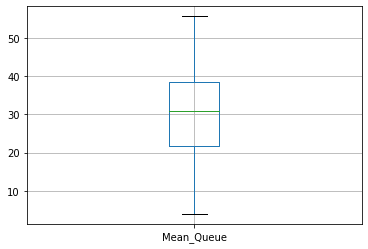

In [57]:
import matplotlib.pyplot as plt
results_df.boxplot("Mean_Queue")
plt.show()

### Warm Up

A potential problem in our DES models is that, by default, we assume that the system is empty of entities (e.g. patients) when the system starts. But sometimes we have to work with systems that are never empty (e.g. Emergency Department of a Hospital), and so if we run our model starting from empty, then our results are going to be skewed by the fact that early on in the simulation, there were no or very few people.

Fortunately, there is a simple solution, we can use a warm up period. During a warm up period, our model runs, but it doesn't collect any results. The warm-up period allows the simulation to get to a more representative state before we start collecting results.

The length of this period will vary depending on the system we want to model. We might choose to just set a sufficiently lengthy warm up period to ensure the system is more representative once results start to be taken, or we might run the simulation multiple times and track the results over time to see when a steadier state appears to be reached.

Either way, we can easily add a warm up period to our SimPy models by simply using conditional statements to ensure that results are not collected until the simulation time has passed the warm up period. Let's see an example.

In [58]:
import simpy
import random
from statistics import mean
import csv
import pandas as pd

def patient_generator_weight_loss(env, wl_inter, mean_consult, nurse):

  while True:
    wp = activity_generator_weight_loss(env,mean_consult,nurse)
    env.process(wp)
    t = random.expovariate(1/wl_inter)

    yield env.timeout(t)

def patient_generator_test(env, t_inter, mean_test, nurse):

  while True:
    tp = activity_generator_test(env,mean_consult,nurse)
    env.process(tp)
    t = random.expovariate(1/t_inter)

    yield env.timeout(t)

In [59]:
def activity_generator_weight_loss(env, mean_consult, nurse):
  global queuing_times_nurse_list
  time_entered_queue = env.now

  with nurse.request() as req: 
    yield req
    
    time_left_queue = env.now
    time_in_queue = time_left_queue - time_entered_queue

    # Only add the results after the warm up period
    if env.now > warm_up_period:
      queuing_times_nurse_list.append(time_in_queue)

    consultation_time = random.expovariate(1/mean_consult)
    yield env.timeout(consultation_time)

In [60]:
def activity_generator_test(env, mean_test, nurse):
  global queuing_times_nurse_list
  time_entered_queue_t = env.now

  with nurse.request() as req: 
    yield req
    
    time_left_queue_t = env.now
    time_in_queue_t = time_left_queue_t - time_entered_queue_t

    # Only add the results after the warm up period
    if env.now > warm_up_period:
      queuing_times_nurse_list.append(time_in_queue_t)

    consultation_time = random.expovariate(1/mean_test)
    yield env.timeout(consultation_time)

In [61]:
# Set up number of replicas of the simulation and a seed
n_runs = 100
random.seed(2023)
# Specify the results and the warm up periods
# We have to also modify the activities generators only recording 
# results after the warm up period.
results_collection_period = 120
warm_up_period = 120

# Create a file to store the results of each run and write the header
with open("nurse_results_warm_up.csv", "w") as f:
  writer = csv.writer(f, delimiter = ",")
  writer.writerow(["Run", "Mean_Queue"])
for run in range(n_runs):
  # Set up the simulation enviroment
  env = simpy.Environment()
  # Set up resources
  nurse = simpy.Resource(env, capacity = 1)
  # Set up parameters
  wl_inter = 8
  t_inter = 10
  mean_consult = 10
  mean_test = 3
  # Create the empty list in the global environment
  queuing_times_nurse_list = []
  # Start the arrivals generators, in this case we have two.
  env.process(patient_generator_weight_loss(env,wl_inter, mean_consult, nurse))
  env.process(patient_generator_test(env,t_inter, mean_test, nurse))
  # Run the simulation
  env.run(until=240)
  # Results
  mean_queue = mean(queuing_times_nurse_list)
  # Set up list to write to file in this run
  list_to_write = [run, mean_queue]
  # Store the results of this run in the file
  with open("nurse_results_warm_up.csv", "a") as f:
    writer = csv.writer(f, delimiter = ",")
    writer.writerow(list_to_write)

In [62]:
results_df = pd.read_csv("nurse_results_warm_up.csv")
average_mean_runs = results_df["Mean_Queue"].mean()
print("The average waiting time along all the replicas of the experiment is of", average_mean_runs, "minutes")

The average waiting time along all the replicas of the experiment is of 99.96355957462922 minutes


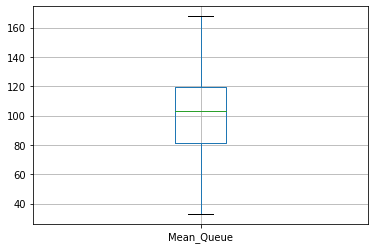

In [63]:
import matplotlib.pyplot as plt
results_df.boxplot("Mean_Queue")
plt.show()

### Containers

So far, we have considered resources as being discrete identifiable entities. But what if our resource was continuous, or if we wanted to model a homogeneus mass of resource. For example, imagine that we are modelling the fuelling of a car, and our resource was petrol.

Or, maybe rather than model number of nurses, we want to model simultaneous nurse time in use, from which we take from and add back to a pool of time as incoming activity fluctuates.

In SimPy, rather than use the Resource class, we can use the Container class for this kind of problems. Let's see an example.

In [65]:
import simpy
import random
from statistics import mean
import csv
import pandas as pd

def patient_generator_dn(env, dn_inter, mean_visit, district_nurse):

  while True:
    p = activity_generator_dn(env,mean_visit,district_nurse)
    env.process(p)
    t = random.expovariate(1/dn_inter)

    yield env.timeout(t)

In [66]:
def activity_generator_dn(env, mean_visit, district_nurse):
  global queuing_times_dn_list

  time_entered_queue_dn = env.now

  # Instead of using the request method, for containers we will just take the 
  # quantity from the resource given a pseudo-random number
  dn_mins_sampled = random.expovariate(1/mean_visit)
  print("DN mins available before request:", district_nurse.level)

  # When we want to take som quantity from the container, we can use the get()
  # method of the Container class, passing the number of unit of the resource
  # we are taking. We also use the yield keyword so the queue will start
  # when we are out of resources in the container.
  yield district_nurse.get(dn_mins_sampled)
  print("DN mins available after request:", district_nurse.level)

  time_left_queue_dn = env.now
  time_in_queue_dn = time_left_queue_dn - time_entered_queue_dn
  queuing_times_dn_list.append(time_in_queue_dn)

  # Here we can obtain the length of the visit. Obviously it is the same as the 
  # amount of resource we have taken from the contaier in this case.
  yield env.timeout(dn_mins_sampled)

  # Once the visit duration has elapsed, we will be back here in the function.
  # SO we can now put back the minutes into the container using the put()
  # method of the container class, again with the yield keyword
  yield district_nurse.put(dn_mins_sampled)

In [67]:
# Set up number of replicas of the simulation and a seed
n_runs = 100
random.seed(2023)

# Create a file to store the results of each run and write the header
with open("dn_nurse_results.csv", "w") as f:
  writer = csv.writer(f, delimiter = ",")
  writer.writerow(["Run", "Mean_Queue"])

for run in range(n_runs):
  # Set up the simulation enviroment
  env = simpy.Environment()

  # Set up resources. In this case it is a container. The initial level of the
  # container and the maximum capacity will be specified. In this experiment
  # makes sense to keep these the same, but in some cases we will need a 
  # maximum greater than the initial capacity.
  district_nurse = simpy.Container(env, init = 1000, capacity = 1000)

  # Set up parameters
  dn_inter = 10
  mean_visit = 60
  # Create the empty list in the global environment
  queuing_times_dn_list = []
  # Start the arrivals generators, in this case we have two.
  env.process(patient_generator_dn(env, dn_inter, mean_visit, district_nurse))
  # Run the simulation
  env.run(until=2000)
  # Results
  mean_queue = mean(queuing_times_dn_list)
  # Set up list to write to file in this run
  list_to_write = [run, mean_queue]
  # Store the results of this run in the file
  with open("dn_nurse_results.csv", "a") as f:
    writer = csv.writer(f, delimiter = ",")
    writer.writerow(list_to_write)

Streaming output truncated to the last 5000 lines.
DN mins available before request: 878.9675985023908
DN mins available after request: 804.1283825113129
DN mins available before request: 925.1607840089222
DN mins available after request: 803.0943160758975
DN mins available before request: 803.0943160758975
DN mins available after request: 766.6471390285931
DN mins available before request: 766.6471390285931
DN mins available after request: 652.2477007590091
DN mins available before request: 652.2477007590091
DN mins available after request: 617.3950868995754
DN mins available before request: 617.3950868995754
DN mins available after request: 560.0576226168478
DN mins available before request: 560.0576226168478
DN mins available after request: 524.6189463572571
DN mins available before request: 524.6189463572571
DN mins available after request: 505.2059855441295
DN mins available before request: 505.2059855441295
DN mins available after request: 430.4417294537182
DN mins available befo

In [13]:
results_df = pd.read_csv("dn_nurse_results.csv")
average_mean_runs = results_df["Mean_Queue"].mean()
print("The average waiting time along all the replicas of the experiment is of", average_mean_runs, "minutes")

The average waiting time along all the replicas of the experiment is of 33.58504766342208 minutes


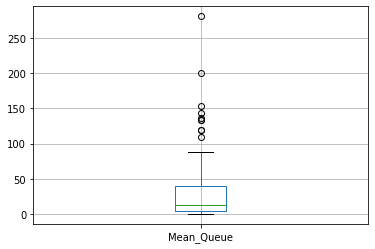

In [14]:
import matplotlib.pyplot as plt
results_df.boxplot("Mean_Queue")
plt.show()